## 1. Hashing ~ HyperLogLog

In [1]:
import dask.dataframe as ddf
import pandas as pd
import hyperloglog as HLL
import k_means_mapreduce as KMR
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

### 1.1. Convert user_id's into binary values (DON'T RUN THIS PART)

For this purpose we have tried out two approaches: 

1. **Use of hash table:** Given that the user_id values are hexadecimal values we could easily convert all integers into binaries individually using the following table:

| String Letter | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    | a    | b    | c    | d    | e    | f    |
|---------------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| Binary        | 0000 | 0001 | 0010 | 0011 | 0100 | 0101 | 0110 | 0111 | 1000 | 1001 | 1010 | 1011 | 1100 | 1101 | 1110 | 1111 |

2. **Use of hash function:** Following the paper provided by the TA's in the homework (more details in the code)

Both approaches gave similar results, however we decided to stick with the second approach due to several reasons:

- It allows us to generalize the approach to cases in which the user_id's are not necesarily in hexadecimal format
- The final binary output is more compressed,allowing us to save the binary values in less memory

In [ ]:
# Convert user_ids into binary values with evenly distributed probabilities of getting 0's and 1's
# Save binary values in data/binary.txt file

header = 'Binary'
for chunk in pd.read_csv('data/hash.txt', sep=" ", header=None, chunksize=100000):
    chunk.columns = ['Binary']

    dask_dataframe = ddf.from_pandas(chunk, npartitions=20)
    users_df_binary = dask_dataframe.map_partitions(HLL.string_to_binary_df, meta=chunk).compute()
    
    users_df_binary.to_csv('data/binary.txt', header=header, mode='a', sep=' ')
    
    header = None

### 1.2. Compute unique count estimate

The procedure to compute the HyperLogLog estimate was the following:

1. Apply has function to user_ids and store hashed values in indepedent .txt file
2. Generate m-substreams (can also be seen as another hash function). Each substreamsn looks at the first b integers of the binary values and classifies them as a separate group. The number of sub-streams (m) are:

\begin{align}
m = 2^{b} \text{with b} \in [4,...,16] 
\end{align}

3. For each sub-stream (m) we compute the number of 0's at the end plus 1. We will take the maximum value of 0's at the end of the binary for each substream and store them in an indepedent list with m elements. We will call this list as $Z$.
4. Given the list of max 0's for each substream we can estimate the number of unique elements as follows:

\begin{align}
E = \alpha(m) \cdot m^{2} \cdot \bigg(\sum_{i=0}^{m}{2^{-Z_{i}}} \bigg)^{-1}
\end{align}

\begin{align}
error(E) = \frac{1.04}{\sqrt{m}}
\end{align}


For more details on the functionality please review the code hyperloglog.py

In [2]:
%%time
cardinality, error = HLL.hyperloglog(path_df='data/binary.txt', 
                                     num_substreams=4096, 
                                     chunksize=1000000)

Wall time: 8min 8s


In [3]:
cardinality

123633420.19914517

In [4]:
error

0.01625

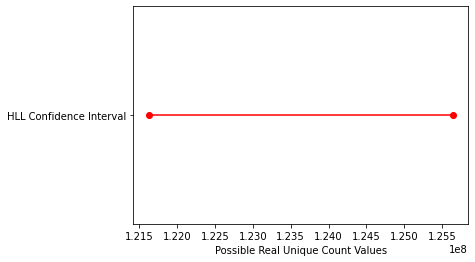

In [5]:
# We have computed the "real unique count" to be 139000000

data_dict = {}
data_dict['Confidence Interval'] = ['HLL Confidence Interval']
data_dict['lower'] = [cardinality-cardinality*error]
data_dict['upper'] = [cardinality+cardinality*error]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='red')
plt.yticks(range(len(dataset)),list(dataset['Confidence Interval']))
plt.xlabel('Possible Real Unique Count Values')
plt.show();

## 3. Bonus Question

In [6]:
data = pd.read_csv('data/clustering.csv')
len(data)

381

In [7]:
X = data[["LoanAmount","ApplicantIncome", 'Credit_History']]
X = X[~X.Credit_History.isnull()]

<Figure size 1440x720 with 0 Axes>

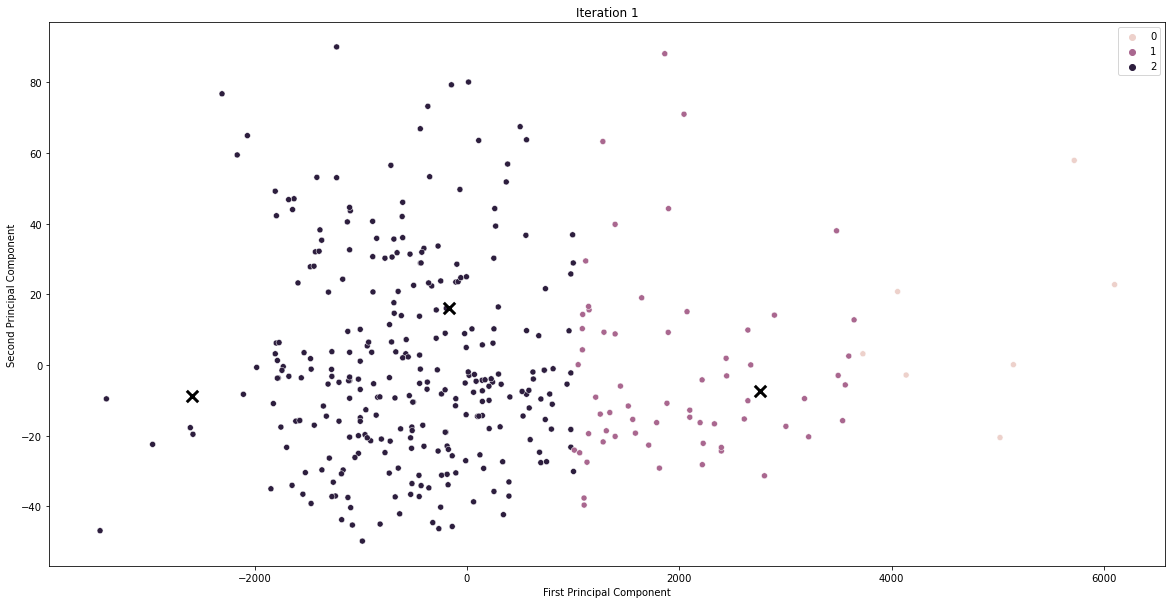

<Figure size 1440x720 with 0 Axes>

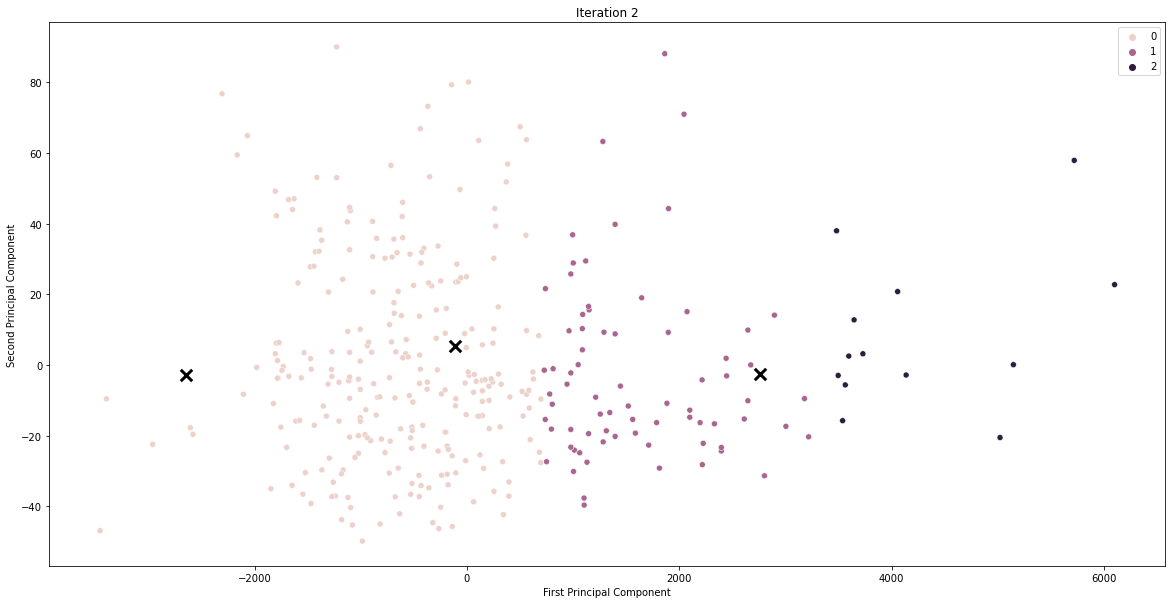

<Figure size 1440x720 with 0 Axes>

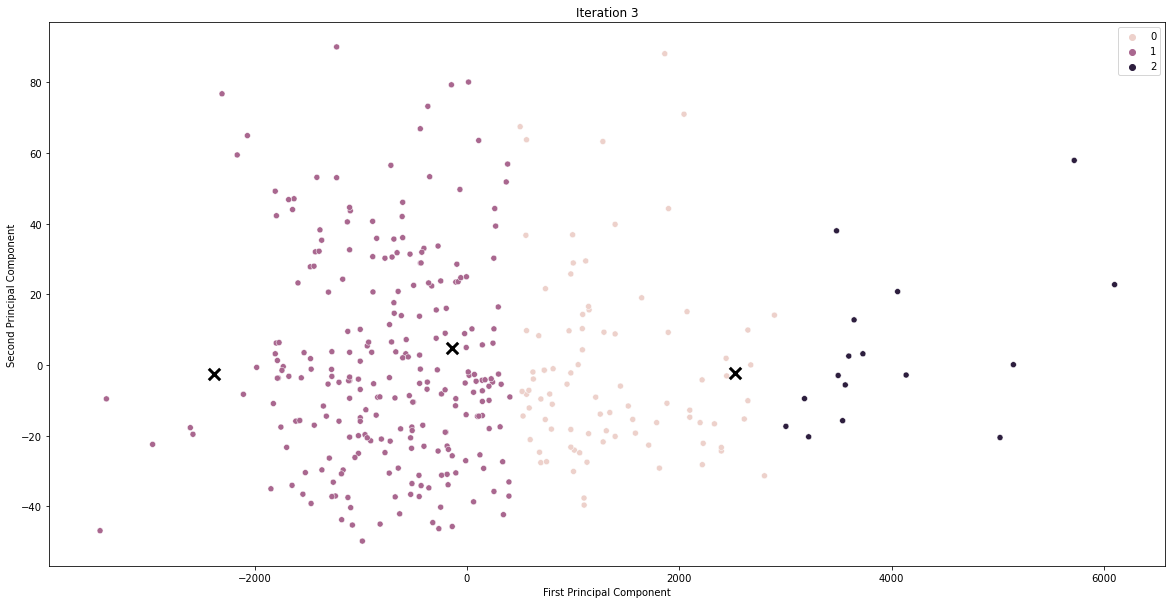

<Figure size 1440x720 with 0 Axes>

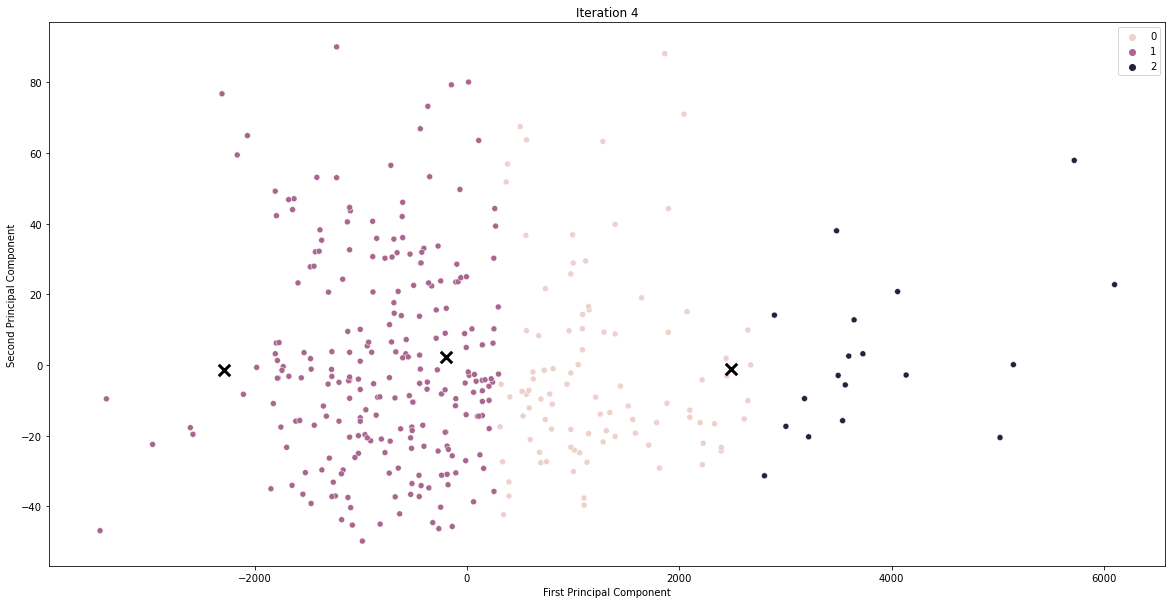

<Figure size 1440x720 with 0 Axes>

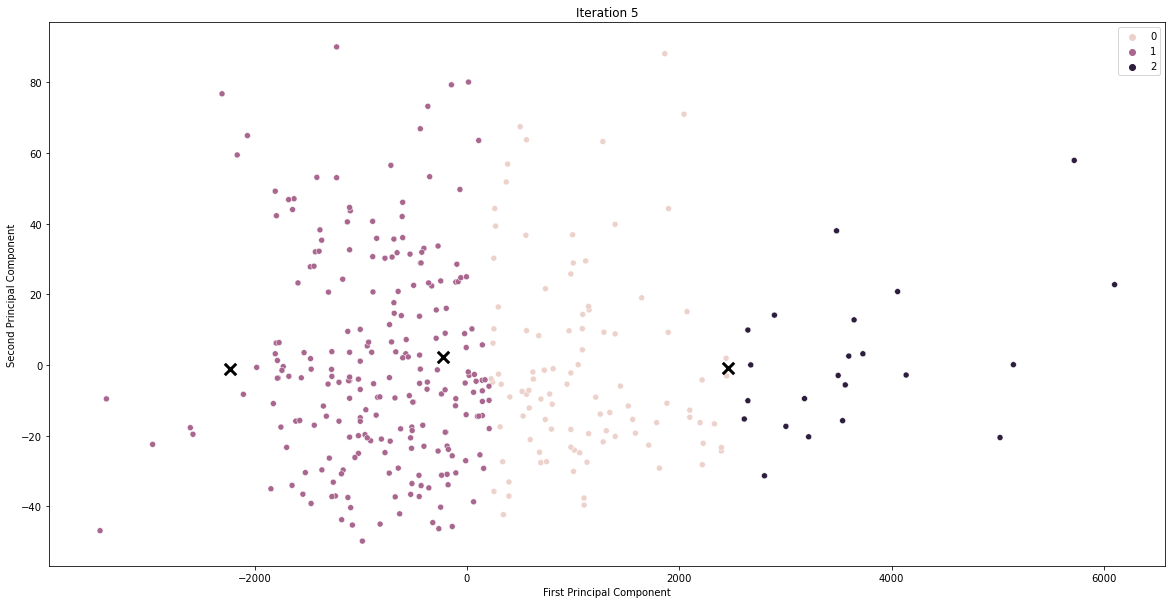

<Figure size 1440x720 with 0 Axes>

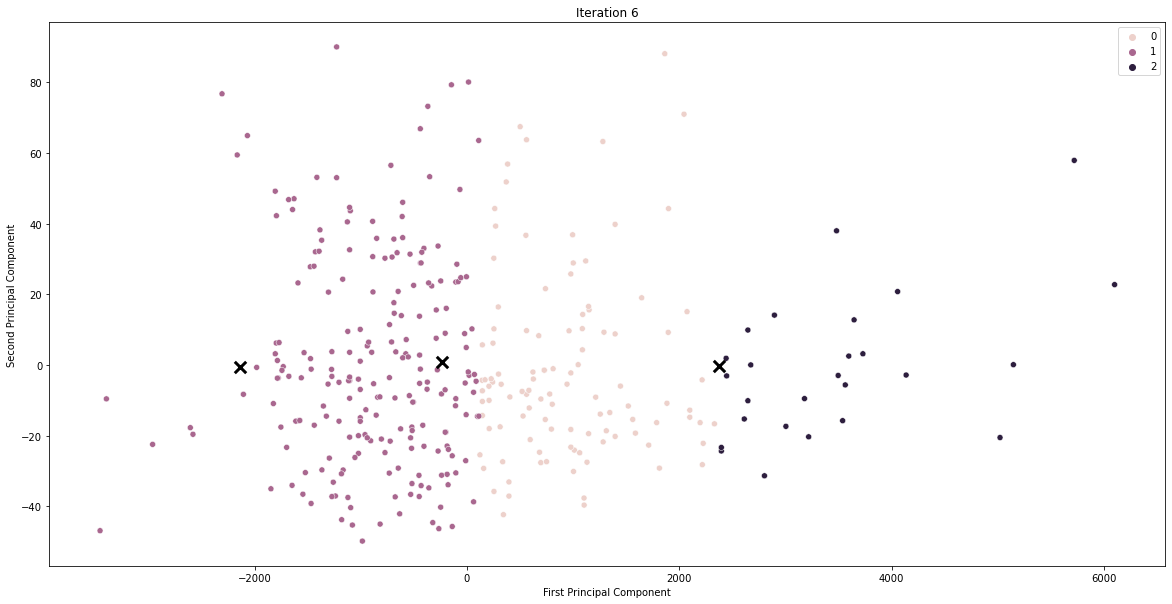

<Figure size 1440x720 with 0 Axes>

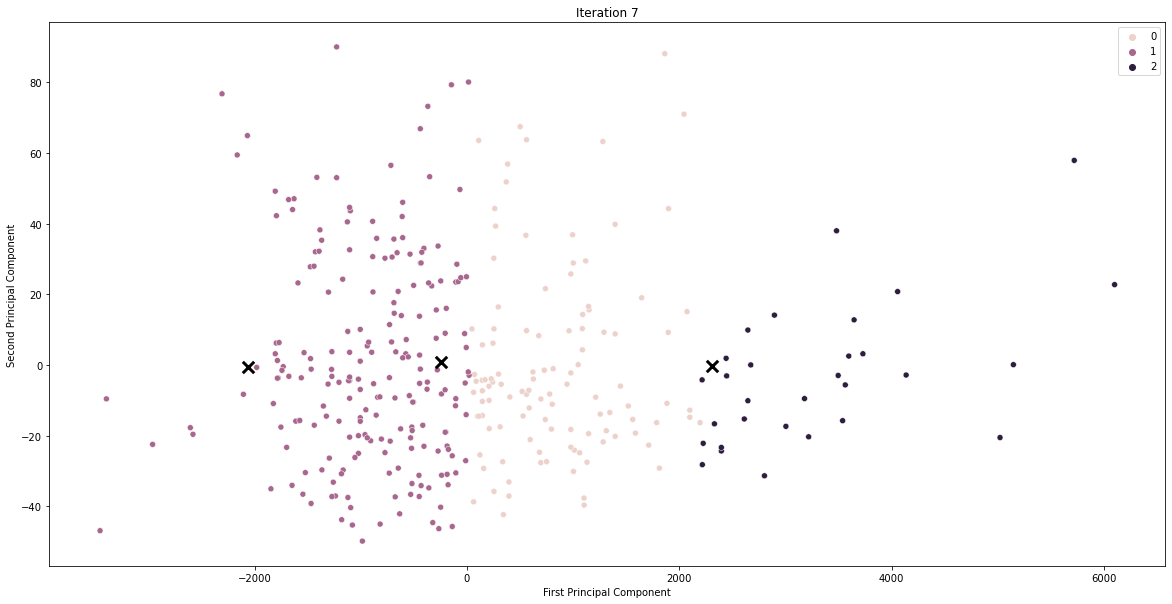

<Figure size 1440x720 with 0 Axes>

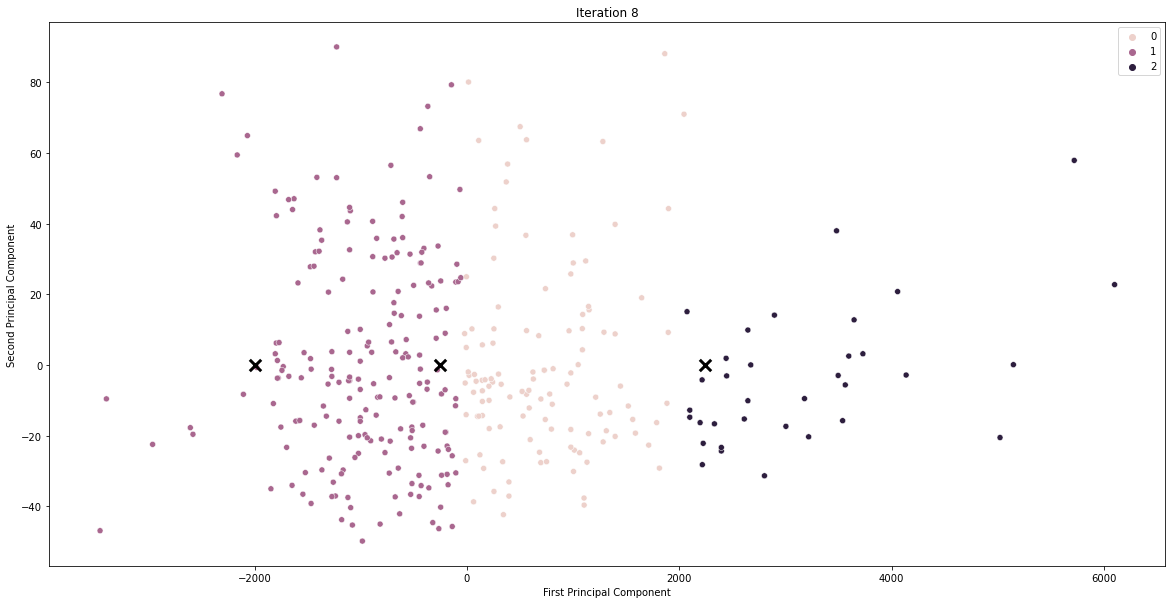

<Figure size 1440x720 with 0 Axes>

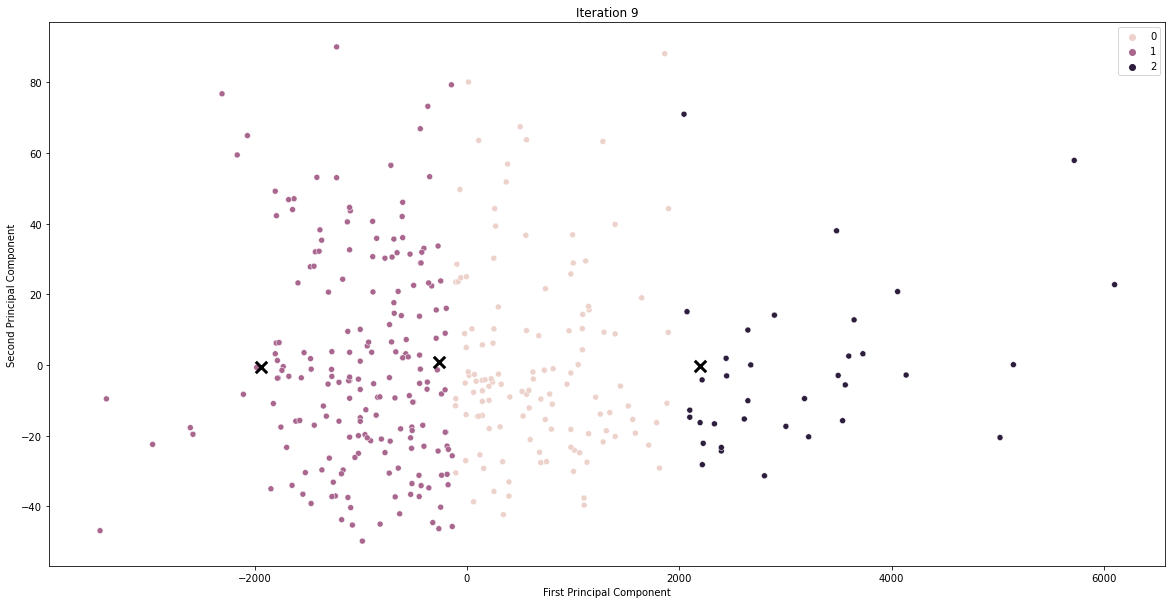

<Figure size 1440x720 with 0 Axes>

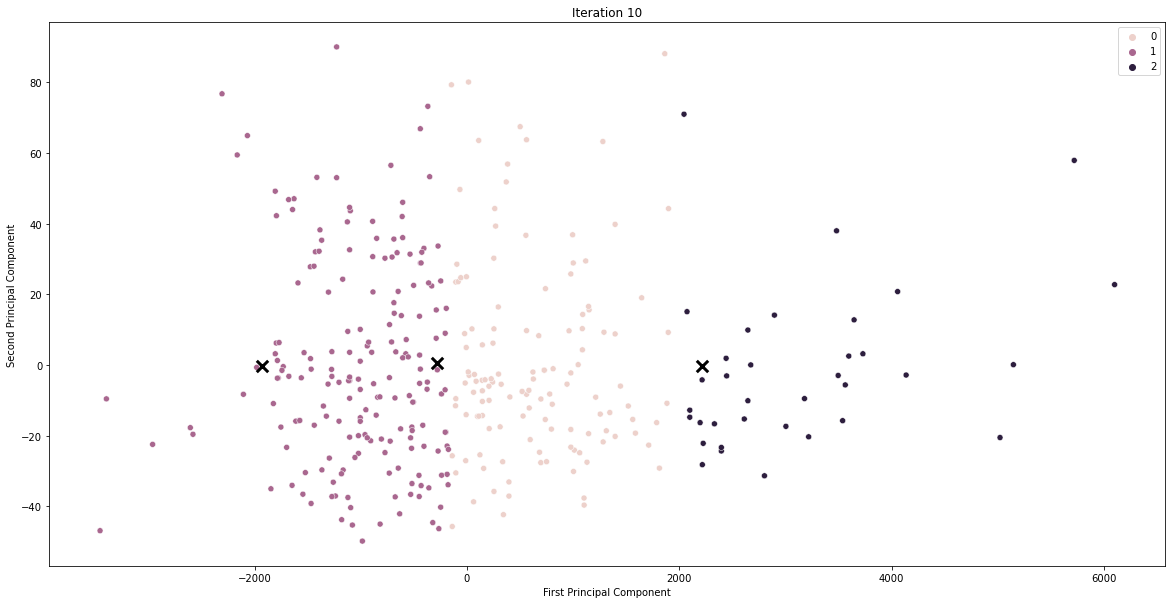

<Figure size 1440x720 with 0 Axes>

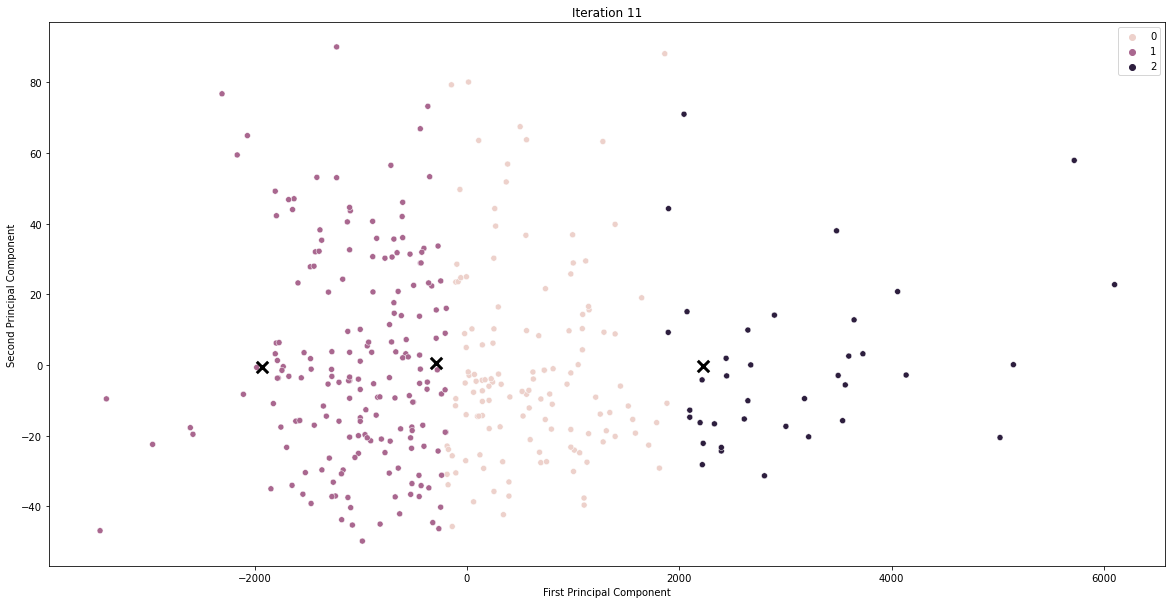

<Figure size 1440x720 with 0 Axes>

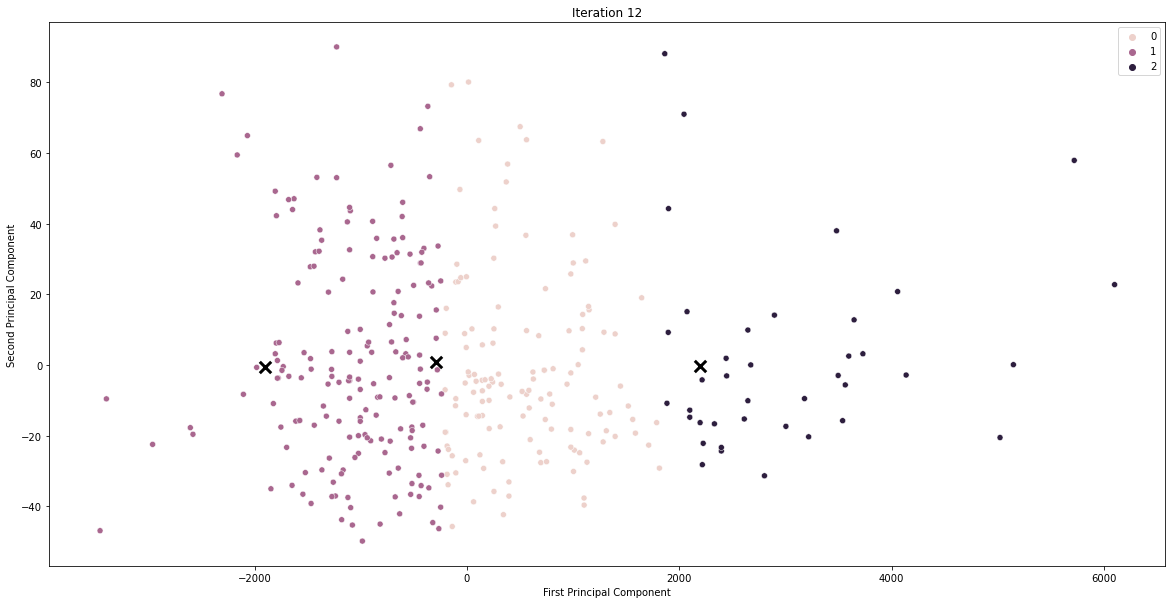

<Figure size 1440x720 with 0 Axes>

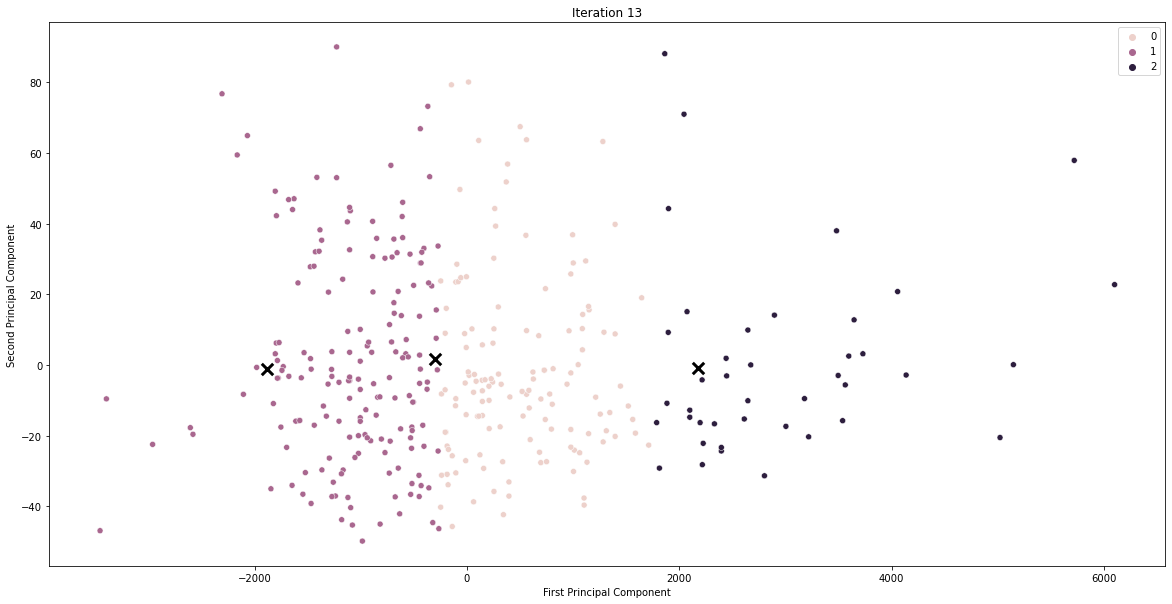

<Figure size 1440x720 with 0 Axes>

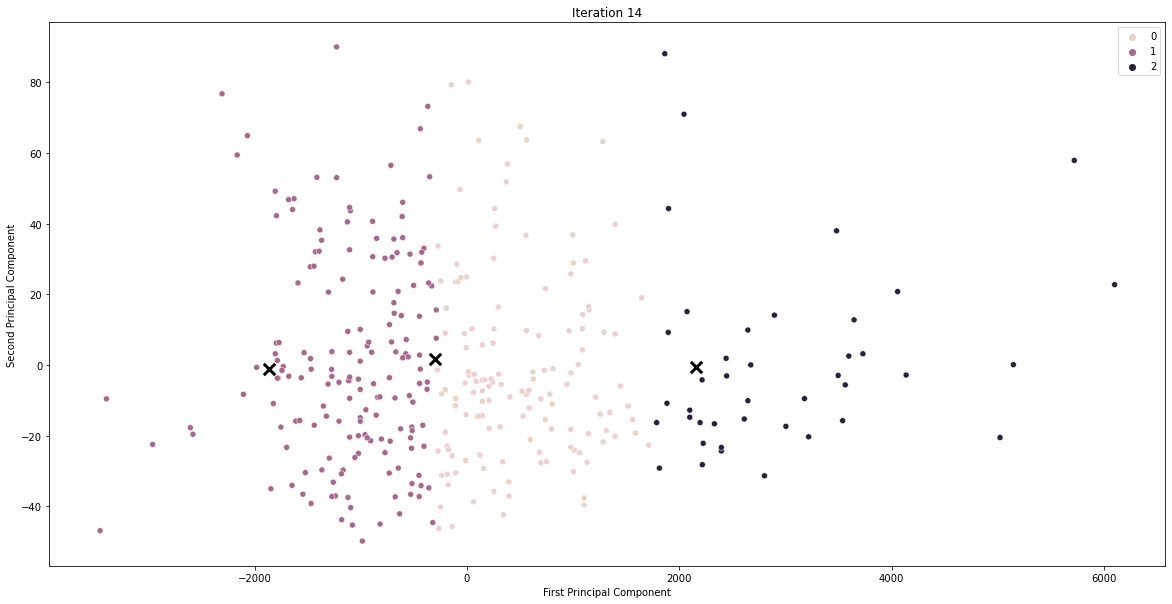

<Figure size 1440x720 with 0 Axes>

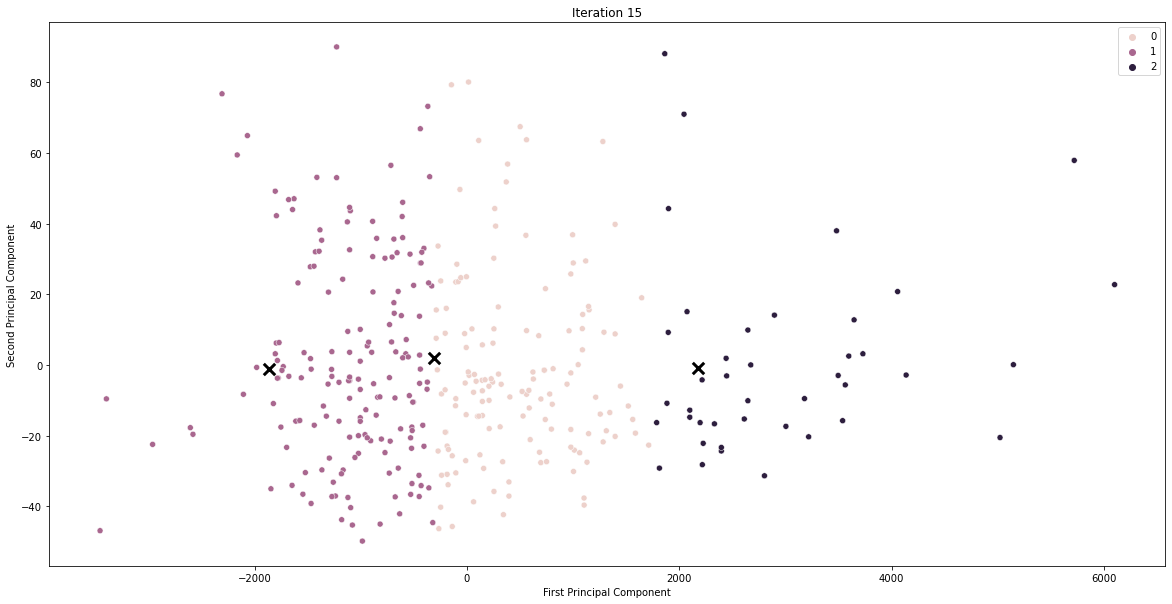

<Figure size 1440x720 with 0 Axes>

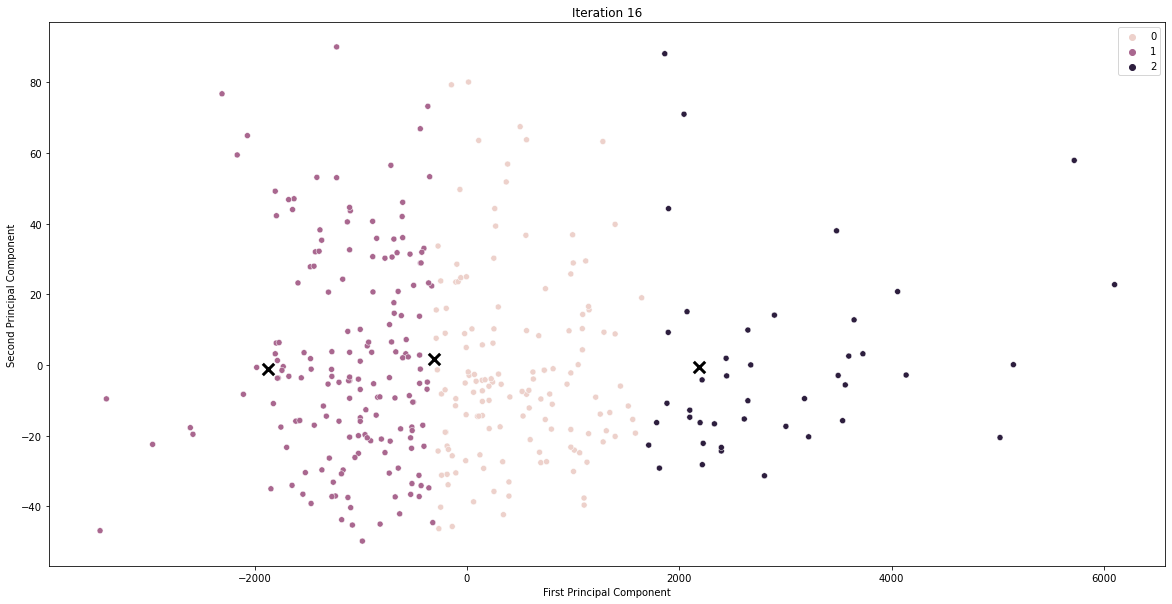

<Figure size 1440x720 with 0 Axes>

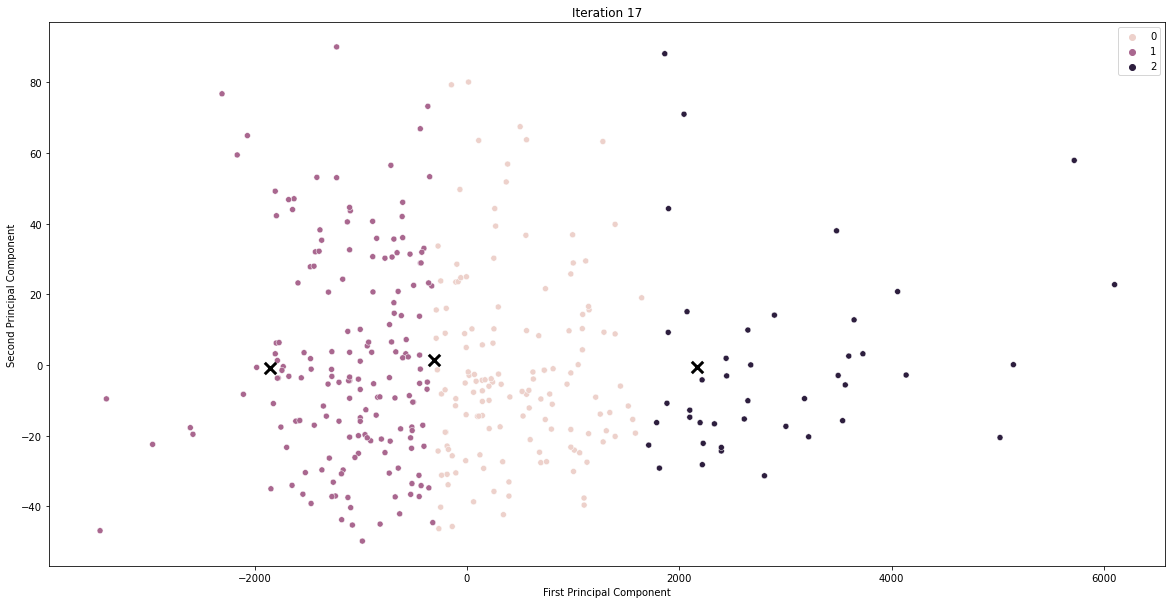

In [8]:
temp = KMR.k_means_map_reduce(X, 3)

In [9]:
temp

,feature_1,feature_2,feature_3,Cluster
0,128.0,4583.0,1.0,0
1,125.0,4950.0,1.0,0
2,76.0,3510.0,0.0,0
3,133.0,4887.0,1.0,0
4,112.0,3365.0,0.0,0
...,...,...,...,...
346,130.0,6783.0,1.0,2
347,26.0,5468.0,1.0,2
348,132.0,5800.0,1.0,2
349,150.0,6406.0,1.0,2


## 4. Algorithmic question

Let us approach this algorithmic problem with a linear sorting technique, the counting sort. 

Counting sort assumes that for a given array, each of the n input elements is an integer in the range 0 to k, for some integer k. The basic idea of counting sort is to determine, for each input element x, the number of elements less than x. This information can be used to place element x directly into its position in the output array.

In our case it is slightly different since the input elements are in the range of s to b, where s is the minimum value of the array A, and s the maximum value. Therefore, while accessing the count-array (C) we need to offset the index with the minimum value of A, since the 0-index element should correspond to the minimum value rather than 0.

In writing the pseudocode for counting sort, we assume that the input is an array &nbsp; **A = [a<sub>1</sub>, a<sub>2</sub>, .. ,a<sub>n</sub>]** &nbsp; with n integer numbers, and thus &nbsp; **length [A] = n**, &nbsp; **min[A] = s**, &nbsp; **max[A] = b** &nbsp;and, the range is defined as &nbsp; **r = b – s**.
We require two other arrays: the array &nbsp;**B = [s, .. ,b]** &nbsp;holds the sorted output, and a count-array &nbsp;**C = [c<sub>0</sub>, .. ,c<sub>b-s</sub>]**&nbsp; with a size of &nbsp;**(b - s) + 1**, since it must contain all the integer numbers between s (included) and b (included), provides a temporary working storage.
<br/><br/>

**COUNTING-SORT(A, B, b-s)**  
1. for $i = 0$ to $[b - s]$
2. $\hspace{0.3cm}C[i] = 0$
3. for $j = 1$ to $n$                                   $\hspace{4.1cm}\rightarrow n = len (A)$
4. $\hspace{0.3cm}C[A[j] - s] = C[A[j] - s] + 1$       $\hspace{1cm}\rightarrow C[i -s]$ now contains the number of elements equal to i.
5. for $i = 1$ to $[b - s]$
6. $\hspace{0.3cm}C[i] = C[i] + C[i -1]$     $\hspace{2.4cm}\rightarrow C[i -s]$ now contains the number of elements less than or equal to i.
7. for $j = n$ to $1$
8. $\hspace{0.3cm}B[C[A[j] - s]] = A[j]$
9. $\hspace{0.3cm}C[A[j] - s] = C[A[j] - s] - 1$

After the initialization in the for loop of lines 1–2, we inspect each input element in the for loop of lines 3–4. If the value of an input element is i, we increment $C[i-s]$. <br />Thus, after line 4, $C[i - s]$ holds the number of input elements equal to i for each integer present in the array A. <br />In lines 5–6, we determine for each $i = 1,..., [b -s]$, how many input elements are less than or equal to i by keeping a running sum of the array C. <br />Finally, in the for loop of lines 7–9, we place each element $A[j]$ in its correct sorted position in the output array B. If all n elements are distinct, then when we first enter line 9, for each $A[j]$, the value $C[A[j] - s]$ is the correct final position of $A[j]$ in the output array, since there are $C[A[j] - s]$ elements less than or equal to $A[j] - s$. <br />Because the elements might not be distinct, we decrement $C[A[j] - s]$ each time we place a value $A[j]$ into the B array. Decrementing $C[A[j] - s]$ causes the next input element with a value equal to $A[j]$, if one exists, to go to the position immediately before $A[j]$ in the output array.<br /><br />
**SO HOW MUCH TIME DOES THE COUNTING SORT REQUIRE?**

The for loop of **lines 1–2** takes time in the order of $O(b-s)$ since the size of the count-array(C) is **r = b – s**, while the for loop of **lines 3–4** has a computational time of $O(n)$ since we are looping through the length of the array to be sorted (len(A) = n), likewise the for loop of **lines 5–6** has a running time of $O(b-s)$, and the for loop of **lines 7–9** takes time $O(n)$. <br />Thus, the overall time complexity of the algorithm is approximately &nbsp; $O(n + (b-s)) = O(n + r)$.